In [1]:
# Implementation of MoE follows the code below
# https://github.com/lucidrains/mixture-of-experts/blob/master/mixture_of_experts/mixture_of_experts.py

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import math
import numpy as np
import matplotlib.pyplot as plt
from math import log, e
import torch.optim as optim
import pickle
import random

torch.manual_seed(2)
np.random.seed(2)
random.seed(2)

plt.rcParams.update({'font.size': 13})

DATA_NUM = 16000
CLUSTER_NUM = 4
EXPERT_NUM = 8
PATCH_NUM = 4
PATCH_LEN = 50

In [3]:
#utils

def entropy(dispatch, base=None):
    """ Computes entropy of label distribution. """
    n_expert = torch.sum(dispatch, axis=0)
    n_total = torch.sum(dispatch)
    
    prob = dispatch / n_expert
    ent = - torch.nansum(prob*torch.log(prob), axis=0)
    ent = torch.sum((n_expert / n_total) * ent)
    
    return ent

In [4]:
class ConvNet(nn.Module):
    def __init__(self, input_dim, out_channel, patch_num, small=True, nonlinear=True):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv1d(1, out_channel*2, int(input_dim/patch_num), int(input_dim/patch_num))        
        # small initialization
        if small:
            self.conv1.weight = torch.nn.Parameter(self.conv1.weight*0.001) 
            self.conv1.bias = torch.nn.Parameter(self.conv1.bias*0.001) 
        self.out_channel = out_channel
        self.nonlinear = nonlinear

    def forward(self, x):
        x = self.conv1(x)
        if self.nonlinear:
            x = x**3
        x = torch.sum(x,2)
        output = torch.stack([torch.sum(x[:,:self.out_channel],1), torch.sum(x[:,self.out_channel:],1)]).transpose(1,0)
        return output
    

# top 1 hard routing
def top1(t):
    values, index = t.topk(k=1, dim=-1)
    values, index = map(lambda x: x.squeeze(dim=-1), (values, index))
    return values, index


def cumsum_exclusive(t, dim=-1):
    num_dims = len(t.shape)
    num_pad_dims = - dim - 1
    pre_padding = (0, 0) * num_pad_dims
    pre_slice   = (slice(None),) * num_pad_dims
    padded_t = F.pad(t, (*pre_padding, 1, 0)).cumsum(dim=dim)
    return padded_t[(..., slice(None, -1), *pre_slice)]


def safe_one_hot(indexes, max_length):
    max_index = indexes.max() + 1
    return F.one_hot(indexes, max(max_index + 1, max_length))[..., :max_length]


class Router(nn.Module):
    def __init__(self, input_dim, out_dim, patch_num, strategy='top1',noise=None):
        super(Router, self).__init__()
        self.conv1 = nn.Conv1d(1, out_dim, int(input_dim/patch_num), int(input_dim/patch_num),bias=False)
        self.out_dim = out_dim
        self.strategy = strategy
        if self.strategy == 'top1':
            if noise is None:
                self.noise = torch.rand(DATA_NUM,out_dim).cuda()
            else:
                self.noise = noise
        # zero initialization
        self.reset_parameters()
    
    def reset_parameters(self):
        self.conv1.weight = torch.nn.Parameter(self.conv1.weight * 0)
            
    def forward(self, x):      
        x = self.conv1(x)
        x = torch.sum(x,2)
        if self.strategy == 'top1':
            output = x + self.noise
        return output

In [5]:
class MoE(nn.Module):
    def __init__(self, input_dim, out_channel, patch_num, expert_num, strategy='top1', nonlinear=True, noise=None):
        super(MoE, self).__init__()
        self.router = Router(input_dim, expert_num, patch_num, strategy=strategy, noise=noise)
        self.models = nn.ModuleList()
        for i in range(expert_num):
            self.models.append(ConvNet(input_dim, out_channel, patch_num, nonlinear=nonlinear))
        self.strategy = strategy
        self.expert_num = expert_num

    def forward(self, x):
        select = self.router(x)
        # top 1 or choose 1 according to probability
        if self.strategy == 'top1':
            gate, index = top1(select)
        else:
            gate, index = choose1(select)
        
        mask = F.one_hot(index, self.expert_num).float()

        density = mask.mean(dim=-2)
        density_proxy = select.mean(dim=-2)
        loss = (density_proxy * density).mean() * float(self.expert_num ** 2)

        mask_count = mask.sum(dim=-2, keepdim=True)
        mask_flat = mask.sum(dim=-1)

        combine_tensor = (gate[..., None, None] * mask_flat[..., None, None]
                          * F.one_hot(index, self.expert_num)[..., None])
                          
        dispatch_tensor = combine_tensor.bool().to(combine_tensor)
        dispatch_result = dispatch_tensor.squeeze(-1)
        
        expert_inputs = torch.einsum('bnd,ben->ebd', x, dispatch_tensor).unsqueeze(2)
        
        output = []
        for i in range(self.expert_num):
            output.append(self.models[i](expert_inputs[i]))
        
        output = torch.stack(output)
        output = torch.einsum('ijk,jil->il', combine_tensor, output)
        output = F.softmax(output,dim=1)

        return output, dispatch_result, loss

In [6]:
def train(model, criterion, data, labels, optimizers, epochs, 
          load_balancing=False, verbose=True, early_stopping=True, eps=0.02):
    
    expert_acc_train = [[[] for x in range(CLUSTER_NUM)] for x in range(EXPERT_NUM)]
    expert_inner_train = [[[] for x in range(CLUSTER_NUM)] for x in range(EXPERT_NUM)]
    
    router_acc_train = [[] for x in range(CLUSTER_NUM)]
    router_inner_train = [[] for x in range(CLUSTER_NUM)]

    entropy_record = []
    min_loss = float("inf")

    for epoch in range(epochs):  
        
        for optimizer in optimizers:
            optimizer.zero_grad()
        outputs, dispatch, load_balancing_loss = model(data)
        
        e = entropy(torch.stack([dispatch[train_cluster_idx[0]].squeeze(-1).sum(dim=0),
                                 dispatch[train_cluster_idx[1]].squeeze(-1).sum(dim=0),
                                 dispatch[train_cluster_idx[2]].squeeze(-1).sum(dim=0),
                                 dispatch[train_cluster_idx[3]].squeeze(-1).sum(dim=0)]))
        entropy_record.append(e)
        
        if load_balancing:
            loss = criterion(outputs, labels) + 0.001 * load_balancing_loss
        else:
            loss = criterion(outputs, labels)
            
        if early_stopping:
            if loss.item() <= min_loss:
                min_loss = loss.item()
            elif loss > min_loss+eps or loss <= 0.314:
                break
        loss.backward()
                
        for optimizer in optimizers:
            optimizer.step()
        
        if epoch%100 == 0:
            if verbose:
                print('Epoch %d --- loss: %.3f' % (epoch + 1, loss.item()))
            
    print('Finished Training')
    return expert_acc_train,expert_inner_train,router_acc_train,router_inner_train, dispatch, entropy_record


def test(model, criterion, data, labels, verbose=True):
    correct = 0
    
    with torch.no_grad():
        outputs,_,_ = model(data) 
        predicted = torch.max(outputs.data, 1).indices
        correct += (predicted == labels).sum().item()

    if verbose:
        print('Accuracy of the network on the %d test images: %.4f %%' % (data.shape[0],
            100 * correct / data.shape[0]))
    
    return 100 * correct / data.shape[0]

In [7]:
training_data = torch.load('synthetic_data_s2/train_data.pt')
training_labels = torch.load('synthetic_data_s2/train_labels.pt')

test_data = torch.load('synthetic_data_s2/test_data.pt')
test_labels = torch.load('synthetic_data_s2/test_labels.pt')

centers = torch.load('synthetic_data_s2/centers.pt')
features = torch.load('synthetic_data_s2/features.pt')

with open("synthetic_data_s2/train_cluster", "rb") as fp:  
    train_cluster_idx = pickle.load(fp)
    
with open("synthetic_data_s2/test_cluster", "rb") as fp:  
    test_cluster_idx = pickle.load(fp)

In [8]:
from torch.optim.optimizer import Optimizer, required
from torch.optim import _functional

class NormalizedGD(Optimizer):
    def __init__(self, params, lr=required, momentum=0, dampening=0,
                 weight_decay=0, nesterov=False):
        if lr is not required and lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if momentum < 0.0:
            raise ValueError("Invalid momentum value: {}".format(momentum))
        if weight_decay < 0.0:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))

        defaults = dict(lr=lr, momentum=momentum, dampening=dampening,
                        weight_decay=weight_decay, nesterov=nesterov)
        if nesterov and (momentum <= 0 or dampening != 0):
            raise ValueError("Nesterov momentum requires a momentum and zero dampening")
        super(NormalizedGD, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(NormalizedGD, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('nesterov', False)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            params_with_grad = []
            d_p_list = []
            momentum_buffer_list = []
            weight_decay = group['weight_decay']
            momentum = group['momentum']
            dampening = group['dampening']
            nesterov = group['nesterov']
            lr = group['lr']

            for p in group['params']:
                if p.grad is not None:
                    # Normalizing 
                    if p.grad.norm() != 0:
                        p.grad /= p.grad.norm()
                        
                    params_with_grad.append(p)
                    d_p_list.append(p.grad)

                    state = self.state[p]
                    if 'momentum_buffer' not in state:
                        momentum_buffer_list.append(None)
                    else:
                        momentum_buffer_list.append(state['momentum_buffer'])

            _functional.sgd(params_with_grad,
                  d_p_list,
                  momentum_buffer_list,
                  weight_decay=weight_decay,
                  momentum=momentum,
                  lr=lr,
                  dampening=dampening,
                  nesterov=nesterov,
                  ) # add "maximize=False" if new version

            # update momentum_buffers in state
            for p, momentum_buffer in zip(params_with_grad, momentum_buffer_list):
                state = self.state[p]
                state['momentum_buffer'] = momentum_buffer

        return loss

## Entropy change during training

In [9]:
num_epochs = 501
entropy_records = []
for i in range(10):

    nonlinear_mixture = MoE(200, 8, PATCH_NUM, EXPERT_NUM, strategy='top1').cuda()
    criterion = torch.nn.CrossEntropyLoss()

    optimizer = NormalizedGD(nonlinear_mixture.models.parameters(), lr=0.001)
    optimizer2 = torch.optim.SGD(nonlinear_mixture.router.parameters(), lr=0.1) 

    _, _, _, _, _, entropy_record = train(nonlinear_mixture, criterion, training_data, training_labels, 
                                          [optimizer,optimizer2], num_epochs, 
                                          load_balancing=False, verbose=False, early_stopping=False)

    entropy_records.append(torch.stack(entropy_record))
    test(nonlinear_mixture, criterion, test_data, test_labels)
    
entropy_avg_noise = torch.mean(torch.stack(entropy_records),dim=0)
entropy_std_noise = torch.std(torch.stack(entropy_records),dim=0)

ci_noise = 1.96 * entropy_std_noise/np.sqrt(len(entropy_records))

Finished Training
Accuracy of the network on the 16000 test images: 98.0187 %
Finished Training
Accuracy of the network on the 16000 test images: 98.5187 %
Finished Training
Accuracy of the network on the 16000 test images: 98.6625 %
Finished Training
Accuracy of the network on the 16000 test images: 97.4875 %
Finished Training
Accuracy of the network on the 16000 test images: 98.5563 %
Finished Training
Accuracy of the network on the 16000 test images: 98.7500 %
Finished Training
Accuracy of the network on the 16000 test images: 98.1750 %
Finished Training
Accuracy of the network on the 16000 test images: 97.5625 %
Finished Training
Accuracy of the network on the 16000 test images: 98.4437 %
Finished Training
Accuracy of the network on the 16000 test images: 98.6750 %


In [10]:
num_epochs = 501
entropy_records = []
for i in range(10):

    linear_mixture = MoE(200, 8, PATCH_NUM, EXPERT_NUM, strategy='top1', nonlinear=False).cuda()
    criterion = torch.nn.CrossEntropyLoss()

    optimizer = NormalizedGD(linear_mixture.models.parameters(), lr=0.001)
    optimizer2 = torch.optim.SGD(linear_mixture.router.parameters(), lr=0.1) 

    _, _, _, _, _, entropy_record = train(linear_mixture, criterion, training_data, training_labels, 
                                          [optimizer,optimizer2], num_epochs,
                                          load_balancing=False, verbose=False, early_stopping=False)

    entropy_records.append(torch.stack(entropy_record))
    test(linear_mixture, criterion, test_data, test_labels)
    
entropy_avg_noise_linear = torch.mean(torch.stack(entropy_records),dim=0)
entropy_std_noise_linear = torch.std(torch.stack(entropy_records),dim=0)

ci_noise_linear = 1.96 * entropy_std_noise_linear/np.sqrt(len(entropy_records))

Finished Training
Accuracy of the network on the 16000 test images: 90.9250 %
Finished Training
Accuracy of the network on the 16000 test images: 91.4000 %
Finished Training
Accuracy of the network on the 16000 test images: 91.8375 %
Finished Training
Accuracy of the network on the 16000 test images: 92.8375 %
Finished Training
Accuracy of the network on the 16000 test images: 91.2438 %
Finished Training
Accuracy of the network on the 16000 test images: 89.8812 %
Finished Training
Accuracy of the network on the 16000 test images: 91.8750 %
Finished Training
Accuracy of the network on the 16000 test images: 91.0563 %
Finished Training
Accuracy of the network on the 16000 test images: 91.8500 %
Finished Training
Accuracy of the network on the 16000 test images: 91.2500 %


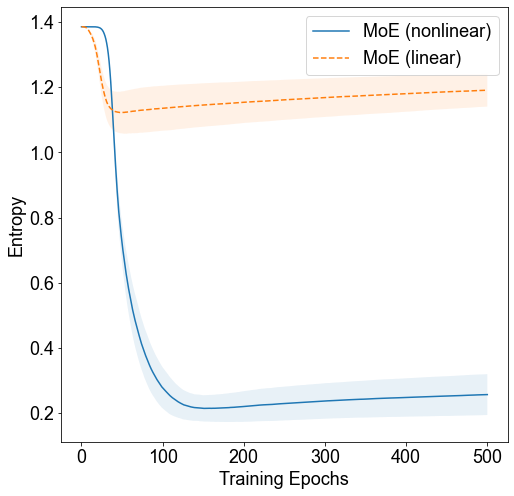

In [11]:
plt.rcParams.update({'font.size': 18, 'figure.figsize': (8,8), 'font.family':'Arial', 'axes.axisbelow':True})
x = np.arange(0,501,1)

plt.plot(x,entropy_avg_noise.cpu(), label='MoE (nonlinear)')
plt.fill_between(x, (entropy_avg_noise.cpu()-ci_noise.cpu()), (entropy_avg_noise.cpu()+ci_noise.cpu()),
                alpha=.1)

plt.plot(x,entropy_avg_noise_linear.cpu(), label='MoE (linear)',linestyle='dashed')
plt.fill_between(x, (entropy_avg_noise_linear.cpu()-ci_noise_linear.cpu()), 
                 (entropy_avg_noise_linear.cpu()+ci_noise_linear.cpu()), alpha=.1)

plt.xlabel('Training Epochs')
plt.ylabel('Entropy')
plt.legend(bbox_to_anchor=(1, 1)) #

# plt.savefig('entropy_toy.pdf',bbox_inches='tight')

In [12]:
torch.save(entropy_avg_noise.cpu(), 'entropy_change_records/MoE_s2.pt')
torch.save(entropy_avg_noise_linear.cpu(), 'entropy_change_records/MoE_linear_s2.pt')

In [13]:
torch.save(ci_noise.cpu(), 'entropy_change_records/MoE_ci_s2.pt')
torch.save(ci_noise_linear.cpu(), 'entropy_change_records/MoE_ci_linear_s2.pt')